In [30]:
# Import the data
import pandas as pd
train_df = pd.read_csv("child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("child-mind-institute-problematic-internet-use/test.csv")

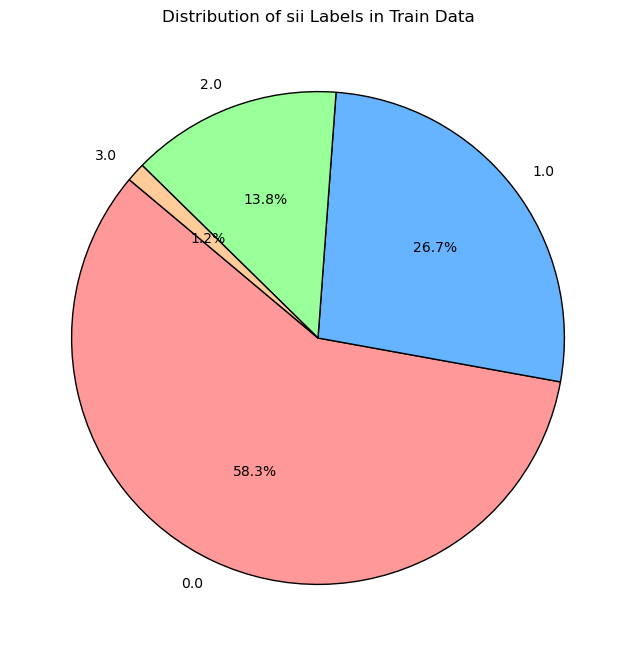

In [31]:
import matplotlib.pyplot as plt

# 自動取得各類別的數量
sizes = train_df['sii'].value_counts()
labels = sizes.index.astype(str)  # 將標籤轉為字串格式方便顯示
sizes = sizes.values  # 提取類別數量

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of sii Labels in Train Data')
plt.show()


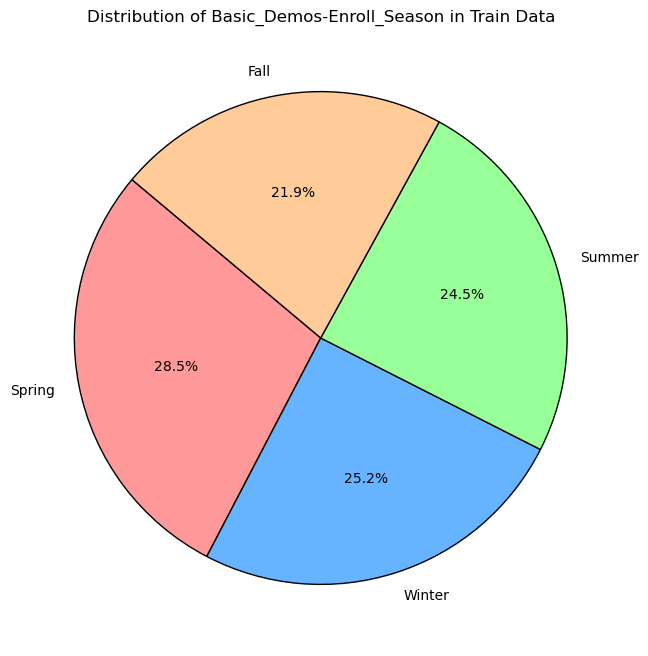

In [32]:
# 自動取得各類別的數量
sizes = train_df['Basic_Demos-Enroll_Season'].value_counts()
labels = sizes.index.astype(str)  # 將標籤轉為字串格式方便顯示
sizes = sizes.values  # 提取類別數量

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Basic_Demos-Enroll_Season in Train Data')
plt.show()

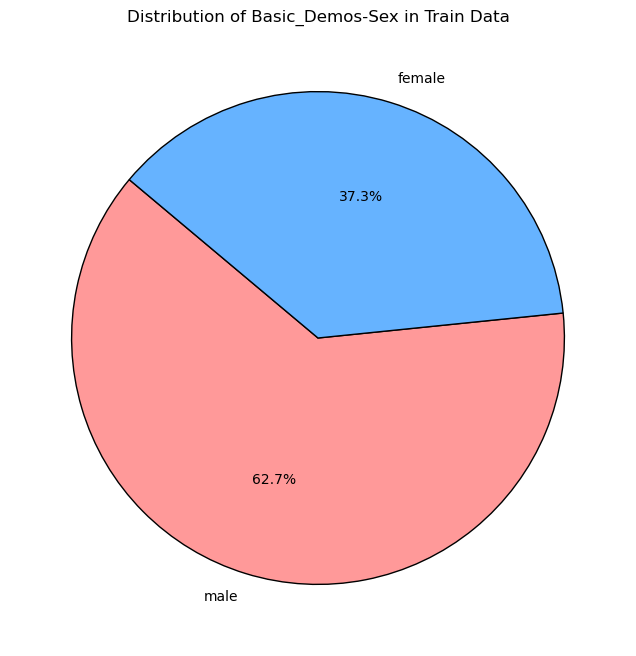

In [33]:
sex_mapping = {0 : 'male', 1 : 'female'}
train_df['Basic_Demos-Sex'] = train_df['Basic_Demos-Sex'].map(sex_mapping)
sex_count = train_df['Basic_Demos-Sex'].value_counts()
labels = sex_count.index.astype(str)
sex_count = sex_count.values  

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sex_count, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Basic_Demos-Sex in Train Data')
plt.show()

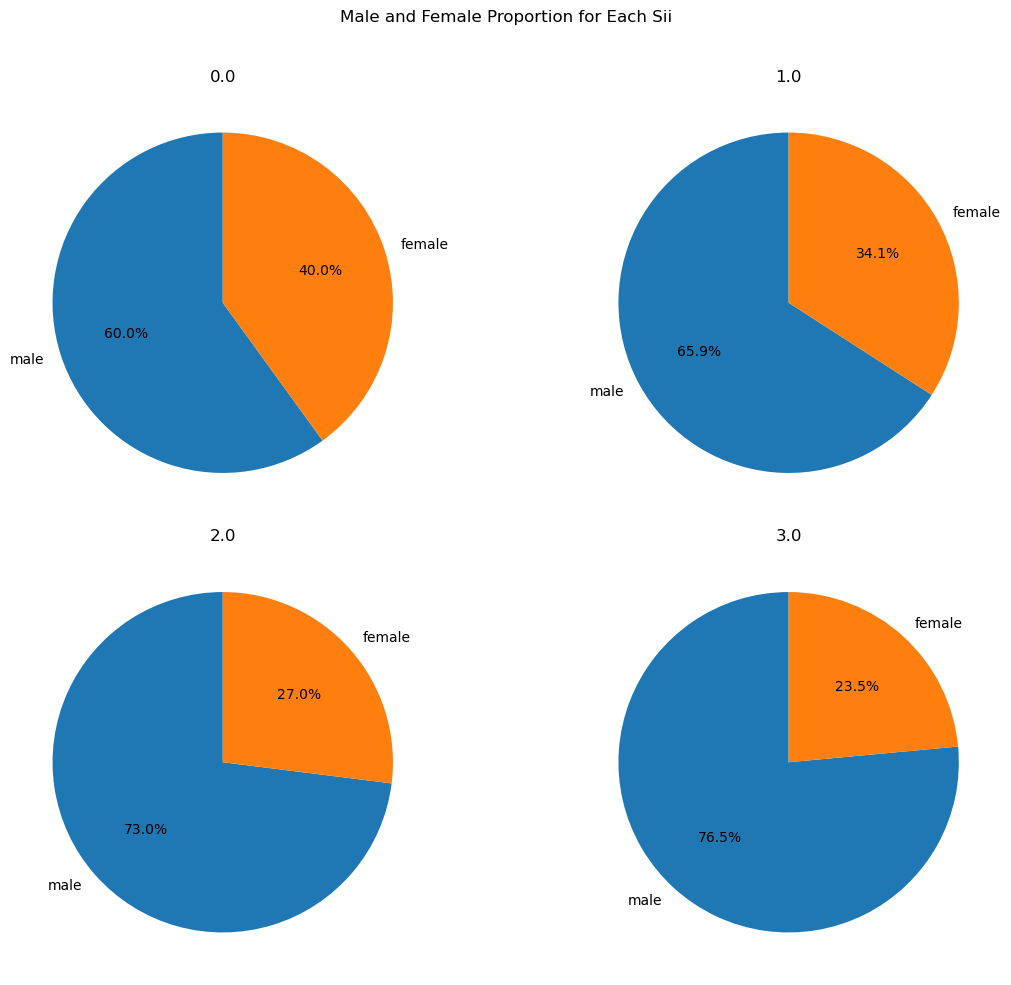

In [35]:
# 設置圖表的大小
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Male and Female Proportion for Each Sii")

# 定義每個target的名稱（根據你的資料設置）
target_labels = ["0.0", "1.0", "2.0", "3.0"]

# 迴圈每個 target，畫出性別比例的圓餅圖
for i, target in enumerate([0, 1, 2, 3]):
    # 選擇與target對應的資料
    data = train_df[train_df['sii'] == target]
    
    # 計算男性和女性的數量
    gender_counts = data['Basic_Demos-Sex'].value_counts()
    
    # 確定子圖位置
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # 畫出圓餅圖
    ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(target_labels[i])

# 調整子圖間距
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 調整大標題和子圖之間的間距
plt.show()


In [39]:
# 建立反向映射字典
reverse_sex_mapping = {'male': 0, 'female': 1}

# 使用 map 函數將文字標籤映射回數值
train_df['Basic_Demos-Sex'] = train_df['Basic_Demos-Sex'].map(reverse_sex_mapping)


In [40]:
corr_matrix = train_df[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
                        'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                        'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
                        'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
                        'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 
                        'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 
                        'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 
                        'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                        'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
                        'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']].corr()

In [41]:
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
Name: PCIAT-PCIAT_Total, dtype: float64


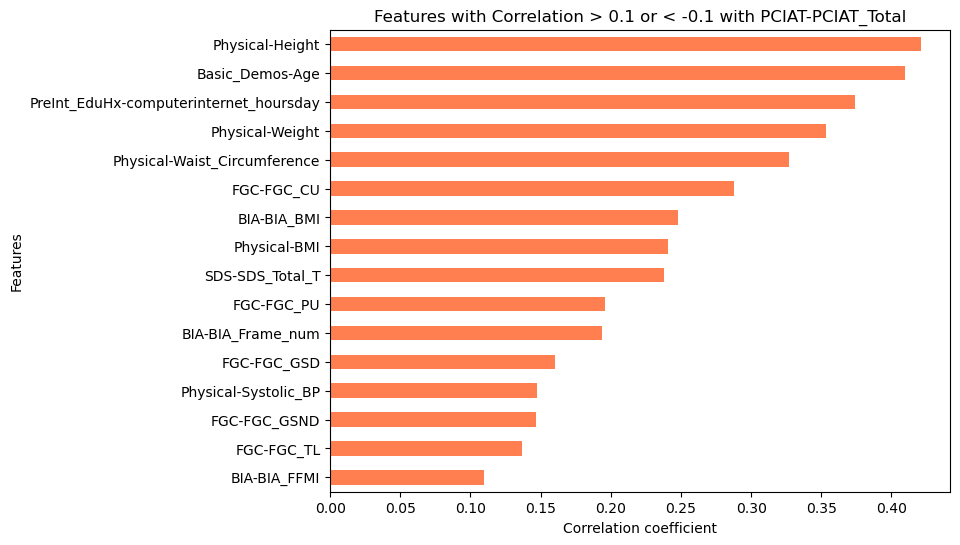

In [42]:
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()